In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

In [6]:
df = pd.read_excel("./Data/OnlineRetailData.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Minute'] = df['InvoiceDate'].dt.minute
df['Second'] = df['InvoiceDate'].dt.second

In [8]:
df.dropna(inplace=True)

<AxesSubplot:xlabel='Quantity'>

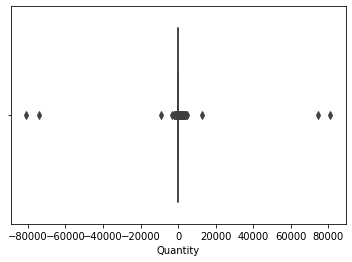

In [9]:
sns.boxplot(x=df['Quantity'])

In [10]:
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = (df['Quantity'] < lower_bound) | (df['Quantity'] > upper_bound)
outlier_indices = df[outliers].index
outlier_indices

Int64Index([     9,     31,     44,     46,     65,     82,     83,     96,
               101,    102,
            ...
            541746, 541747, 541751, 541812, 541833, 541835, 541865, 541866,
            541867, 541868],
           dtype='int64', length=26682)

In [7]:
df = df.drop(outlier_indices)

<AxesSubplot:xlabel='Quantity'>

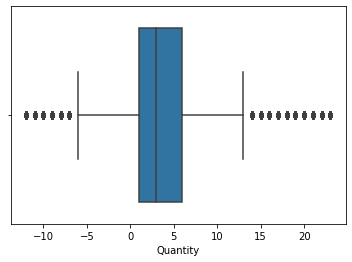

In [8]:
sns.boxplot(x=df['Quantity'])

KeyboardInterrupt: 

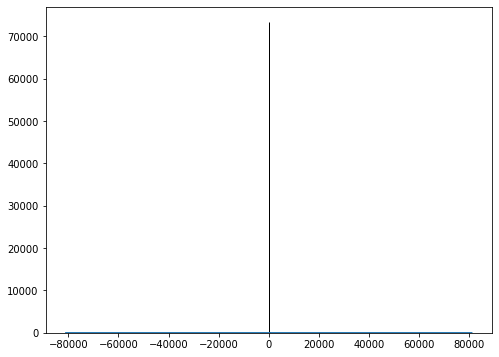

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Quantity'], kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

Since the target variable - Quantity is right-skewed, we can take the square root of quantity to reduce right-skewness.

In [10]:
# df['log_Quantity'] = np.log1p(df['Quantity'])
df['Sqrt_Quantity'] = np.sqrt(df['Quantity'])

c:\Users\shrut\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


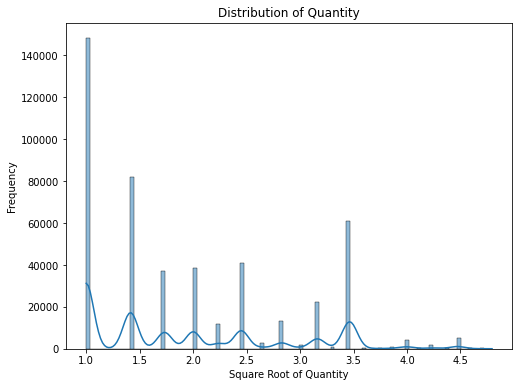

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Sqrt_Quantity'], kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Square Root of Quantity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.dropna(inplace=True)

In [25]:
X = df[['CustomerID', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']]
y = df['Sqrt_Quantity']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*Checking for Linear Regression*

In [27]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [28]:
y_pred = model.predict(X_test)

In [29]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R-squared (R²):", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared (R²): 0.04648938856708529
Mean Squared Error (MSE): 0.8862940648912804
Root Mean Squared Error (RMSE): 0.9414319226005035


Since linear regression is not capturing the underlying patterns, I will try to use regularization and see how that works.

In [30]:
ridge_model = linear_model.Ridge(alpha=0.00001)
ridge_model.fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

c:\Users\shrut\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.24786e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [31]:
lasso_model = linear_model.Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)

In [32]:
def evaluate_model(model, name):
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    print(f"{name} Model:")
    print(f"R-squared (R²): {r2}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

evaluate_model(ridge_model, "Ridge")
evaluate_model(lasso_model, "Lasso")

Ridge Model:
R-squared (R²): 0.046489388567166
Mean Squared Error (MSE): 0.8862940648912054
Root Mean Squared Error (RMSE): 0.9414319226004637
Lasso Model:
R-squared (R²): 0.02475471629666237
Mean Squared Error (MSE): 0.9064965784287904
Root Mean Squared Error (RMSE): 0.9521011387603685


In [33]:
new_data_point = pd.DataFrame({'CustomerID': [12000.0], 'Year': [2020], 'Month': [10], 'Day': [20], 'Hour': [0], 'Minute': [30], 'Second':[30]})
predicted_quantity = ridge_model.predict(new_data_point)

print(f"Predicted Quantity: {predicted_quantity[0]:.2f}")

Predicted Quantity: 3.80


In [34]:
new_data_point = pd.DataFrame({'CustomerID': [12000.0], 'Year': [2020], 'Month': [10], 'Day': [20], 'Hour': [0], 'Minute': [30], 'Second':[30]})
predicted_quantity = lasso_model.predict(new_data_point)

print(f"Predicted Quantity: {predicted_quantity[0]:.2f}")

Predicted Quantity: 2.45


In [35]:
new_data_point = pd.DataFrame({'CustomerID': [12000.0], 'Year': [2020], 'Month': [10], 'Day': [20], 'Hour': [0], 'Minute': [30], 'Second':[30]})
predicted_quantity = model.predict(new_data_point)

print(f"Predicted Quantity: {predicted_quantity[0]:.2f}")

Predicted Quantity: 3.80


Seems like linear regression models are not capturing the underlying patterns in the data. We can try using non-linear models.

*Checking Random Forest*

In [36]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=4, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    mse_fold = mean_squared_error(y_test, y_pred)
    r2_fold = r2_score(y_test, y_pred)

    mse_scores.append(mse_fold)
    r2_scores.append(r2_fold)

In [37]:
mean_mse = sum(mse_scores) / len(mse_scores)
mean_r2 = sum(r2_scores) / len(r2_scores)

print(f"Mean Squared Error (Cross-Validation): {mean_mse:.2f}")
print(f"R-squared (Cross-Validation): {mean_r2:.2f}")

Mean Squared Error (Cross-Validation): 0.71
R-squared (Cross-Validation): 0.23


In [38]:
new_data_point = pd.DataFrame({'CustomerID': [12000.0], 'Year': [2020], 'Month': [10], 'Day': [20], 'Hour': [0], 'Minute': [30], 'Second':[30]})
predicted_quantity = rf_model.predict(new_data_point)

print(f"Predicted Quantity: {predicted_quantity[0]:.2f}")

Predicted Quantity: 2.71


*Checking Gradient Boosting Regressor*

In [39]:
gb_model = GradientBoostingRegressor(n_estimators=1000, learning_rate = 0.1, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)

    mse_fold = mean_squared_error(y_test, y_pred)
    r2_fold = r2_score(y_test, y_pred)

    mse_scores.append(mse_fold)
    r2_scores.append(r2_fold)

In [40]:
mean_mse = sum(mse_scores) / len(mse_scores)
mean_r2 = sum(r2_scores) / len(r2_scores)

print(f"Mean Squared Error (Cross-Validation): {mean_mse:.2f}")
print(f"R-squared (Cross-Validation): {mean_r2:.2f}")

Mean Squared Error (Cross-Validation): 0.65
R-squared (Cross-Validation): 0.30


In [41]:
new_data_point = pd.DataFrame({'CustomerID': [12000.0], 'Year': [2020], 'Month': [10], 'Day': [20], 'Hour': [0], 'Minute': [30], 'Second':[30]})
predicted_quantity = gb_model.predict(new_data_point)

print(f"Predicted Quantity: {predicted_quantity[0]:.2f}")

Predicted Quantity: 2.99
